In [5]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [6]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-Cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [9]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [10]:
df.set_index('Date', inplace=True)

In [11]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [12]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4106, 15, 4)

In [13]:
v = X.reshape(X.shape[0],15, 4)
v[0]

array([[0.03424644, 0.56561183, 0.46282749, 0.22432246],
       [0.31506791, 0.48559383, 0.32255128, 0.49006783],
       [0.        , 0.19792211, 0.        , 0.17891161],
       [0.28082311, 0.1505638 , 0.19881152, 0.55203919],
       [0.73972344, 0.43087195, 0.52369458, 0.85164683],
       [0.52739485, 0.5198189 , 0.37337444, 0.46466227],
       [0.15068401, 0.33208159, 0.10667825, 0.19175134],
       [0.14383571, 0.16844582, 0.12955741, 0.05083703],
       [0.26712158, 0.11605662, 0.33580412, 0.17165809],
       [0.16438226, 0.        , 0.3783434 , 0.        ],
       [0.58904107, 0.19827315, 0.83077978, 0.30402389],
       [0.85616429, 0.55253441, 1.        , 0.89587626],
       [0.5068483 , 0.6084195 , 0.60041228, 0.66894449],
       [1.        , 1.        , 0.93732045, 1.        ],
       [0.17808379, 0.75751779, 0.04412728, 0.39220808]])

In [14]:
y = labels
y = np.array(y)
y.shape

(4106,)

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [17]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 36ms/step - loss: 0.3042 - accuracy: 0.5250 - mse: 0.4305 - weighted_accuracy: 0.3198 - weighted_mse: 0.5168 - val_loss: 0.3008 - val_accuracy: 0.0426 - val_mse: 0.3515 - val_weighted_accuracy: 0.0426 - val_weighted_mse: 0.3515
Epoch 2/200
26/26 [==============================] - 0s 8ms/step - loss: 0.2189 - accuracy: 0.4190 - mse: 0.6850 - weighted_accuracy: 0.4296 - weighted_mse: 0.6941 - val_loss: 0.2939 - val_accuracy: 0.0450 - val_mse: 0.3760 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3760
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1929 - accuracy: 0.3161 - mse: 0.9368 - weighted_accuracy: 0.4802 - weighted_mse: 0.9091 - val_loss: 0.2845 - val_accuracy: 0.0450 - val_mse: 0.4108 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.4108
Epoch 4/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1821 - accuracy: 0.2850 - mse: 1.1040 - weighted_accuracy: 0.5250 - weighte

Epoch 30/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1327 - accuracy: 0.4166 - mse: 1.7326 - weighted_accuracy: 0.7240 - weighted_mse: 1.6382 - val_loss: 0.1824 - val_accuracy: 0.4209 - val_mse: 1.7380 - val_weighted_accuracy: 0.4209 - val_weighted_mse: 1.7380
Epoch 31/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1319 - accuracy: 0.4345 - mse: 1.7427 - weighted_accuracy: 0.7371 - weighted_mse: 1.6629 - val_loss: 0.2006 - val_accuracy: 0.3212 - val_mse: 1.7160 - val_weighted_accuracy: 0.3212 - val_weighted_mse: 1.7160
Epoch 32/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1311 - accuracy: 0.4309 - mse: 1.7716 - weighted_accuracy: 0.7186 - weighted_mse: 1.6881 - val_loss: 0.1753 - val_accuracy: 0.4793 - val_mse: 1.7111 - val_weighted_accuracy: 0.4793 - val_weighted_mse: 1.7111
Epoch 33/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1292 - accuracy: 0.4571 - mse: 1.7767 - weighted_accuracy: 0.7367 - weig

Epoch 59/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1034 - accuracy: 0.6148 - mse: 2.2939 - weighted_accuracy: 0.8268 - weighted_mse: 2.2983 - val_loss: 0.1966 - val_accuracy: 0.4428 - val_mse: 2.3785 - val_weighted_accuracy: 0.4428 - val_weighted_mse: 2.3785
Epoch 60/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1040 - accuracy: 0.6224 - mse: 2.3272 - weighted_accuracy: 0.8188 - weighted_mse: 2.3179 - val_loss: 0.1970 - val_accuracy: 0.4574 - val_mse: 2.5090 - val_weighted_accuracy: 0.4574 - val_weighted_mse: 2.5090
Epoch 61/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1021 - accuracy: 0.6087 - mse: 2.3614 - weighted_accuracy: 0.8224 - weighted_mse: 2.3684 - val_loss: 0.1504 - val_accuracy: 0.6533 - val_mse: 2.3616 - val_weighted_accuracy: 0.6533 - val_weighted_mse: 2.3616
Epoch 62/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1036 - accuracy: 0.6051 - mse: 2.4076 - weighted_accuracy: 0.8253 - weig

26/26 [==============================] - 0s 6ms/step - loss: 0.0800 - accuracy: 0.7238 - mse: 3.2002 - weighted_accuracy: 0.8881 - weighted_mse: 3.2810 - val_loss: 0.1640 - val_accuracy: 0.6423 - val_mse: 3.4685 - val_weighted_accuracy: 0.6423 - val_weighted_mse: 3.4685
Epoch 88/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.7546 - mse: 3.2207 - weighted_accuracy: 0.8994 - weighted_mse: 3.2770 - val_loss: 0.1959 - val_accuracy: 0.5547 - val_mse: 3.2181 - val_weighted_accuracy: 0.5547 - val_weighted_mse: 3.2181
Epoch 89/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0780 - accuracy: 0.7467 - mse: 3.2111 - weighted_accuracy: 0.8987 - weighted_mse: 3.2885 - val_loss: 0.1693 - val_accuracy: 0.6131 - val_mse: 3.3230 - val_weighted_accuracy: 0.6131 - val_weighted_mse: 3.3230
Epoch 90/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0781 - accuracy: 0.7390 - mse: 3.3459 - weighted_accuracy: 0.8938 - weighted_mse: 3.3

Epoch 116/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.8270 - mse: 4.5112 - weighted_accuracy: 0.9302 - weighted_mse: 4.5189 - val_loss: 0.1609 - val_accuracy: 0.7068 - val_mse: 4.7971 - val_weighted_accuracy: 0.7068 - val_weighted_mse: 4.7971
Epoch 117/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0591 - accuracy: 0.8283 - mse: 4.6064 - weighted_accuracy: 0.9306 - weighted_mse: 4.6484 - val_loss: 0.1957 - val_accuracy: 0.6204 - val_mse: 4.6209 - val_weighted_accuracy: 0.6204 - val_weighted_mse: 4.6209
Epoch 118/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0577 - accuracy: 0.8249 - mse: 4.7374 - weighted_accuracy: 0.9338 - weighted_mse: 4.7284 - val_loss: 0.1687 - val_accuracy: 0.6995 - val_mse: 4.7823 - val_weighted_accuracy: 0.6995 - val_weighted_mse: 4.7823
Epoch 119/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0584 - accuracy: 0.8225 - mse: 4.6442 - weighted_accuracy: 0.9286 - 

Epoch 145/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.8864 - mse: 6.2700 - weighted_accuracy: 0.9584 - weighted_mse: 6.1147 - val_loss: 0.1770 - val_accuracy: 0.7190 - val_mse: 6.3058 - val_weighted_accuracy: 0.7190 - val_weighted_mse: 6.3058
Epoch 146/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0423 - accuracy: 0.8849 - mse: 6.3692 - weighted_accuracy: 0.9535 - weighted_mse: 6.1486 - val_loss: 0.1963 - val_accuracy: 0.6898 - val_mse: 6.6173 - val_weighted_accuracy: 0.6898 - val_weighted_mse: 6.6173
Epoch 147/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0417 - accuracy: 0.8681 - mse: 6.4253 - weighted_accuracy: 0.9496 - weighted_mse: 6.2903 - val_loss: 0.1691 - val_accuracy: 0.7616 - val_mse: 6.8533 - val_weighted_accuracy: 0.7616 - val_weighted_mse: 6.8533
Epoch 148/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.8889 - mse: 6.4749 - weighted_accuracy: 0.9571 - 

Epoch 174/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.9144 - mse: 8.4456 - weighted_accuracy: 0.9622 - weighted_mse: 7.7950 - val_loss: 0.2022 - val_accuracy: 0.7482 - val_mse: 8.9524 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 8.9524
Epoch 175/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9157 - mse: 8.5806 - weighted_accuracy: 0.9648 - weighted_mse: 8.0376 - val_loss: 0.2198 - val_accuracy: 0.7080 - val_mse: 8.2401 - val_weighted_accuracy: 0.7080 - val_weighted_mse: 8.2401
Epoch 176/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9090 - mse: 8.5531 - weighted_accuracy: 0.9623 - weighted_mse: 8.0057 - val_loss: 0.2194 - val_accuracy: 0.7555 - val_mse: 9.4393 - val_weighted_accuracy: 0.7555 - val_weighted_mse: 9.4393
Epoch 177/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9153 - mse: 8.7333 - weighted_accuracy: 0.9669 - 

In [21]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2526179552078247
Test accuracy: 0.7189781069755554


In [22]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.559152   -5.290605    0.06858193]
 [-2.4226978  -1.0739564  -0.5335756 ]
 [-2.624598   -1.4292727   1.1059786 ]
 ...
 [-4.6448874  -6.0433626   4.00307   ]
 [-0.63055575 -3.6651413  -0.20399176]
 [-2.004673   -2.6623712   0.9155313 ]]


Counter({2: 644, 1: 74, 0: 104})

In [23]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [24]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 822
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 29
actual holds but predicted buy: 69
actual holds but predicted sell: 97
actual predicted holds: 582
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 16.216216216216218%
Percentage holds correct: 77.80748663101605%
actual buys: 37
actual sells: 37
actual holds: 748


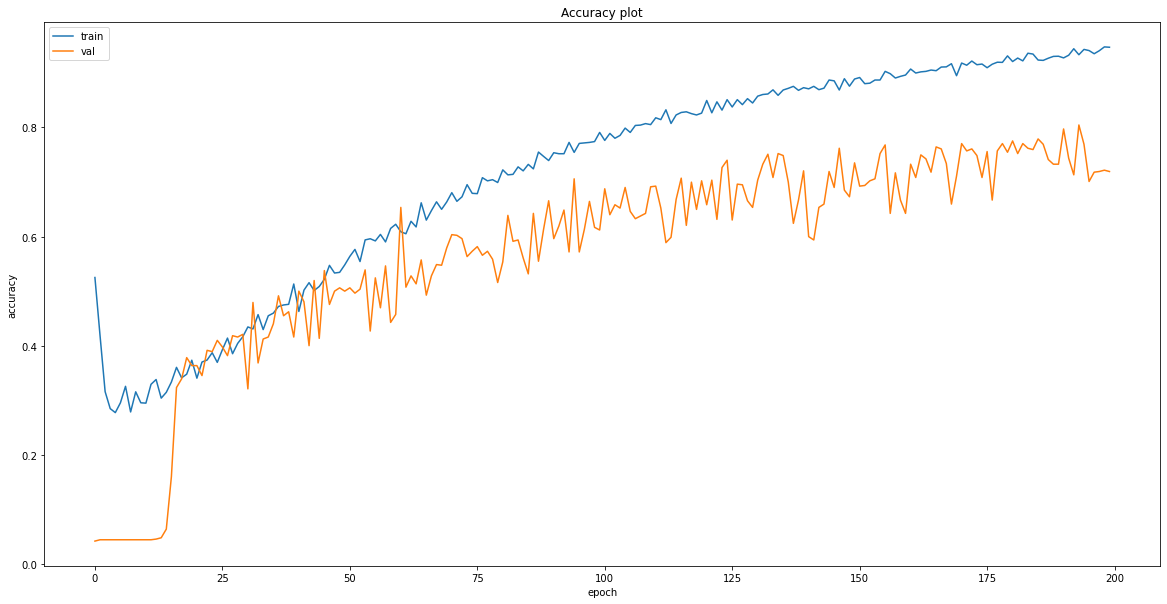

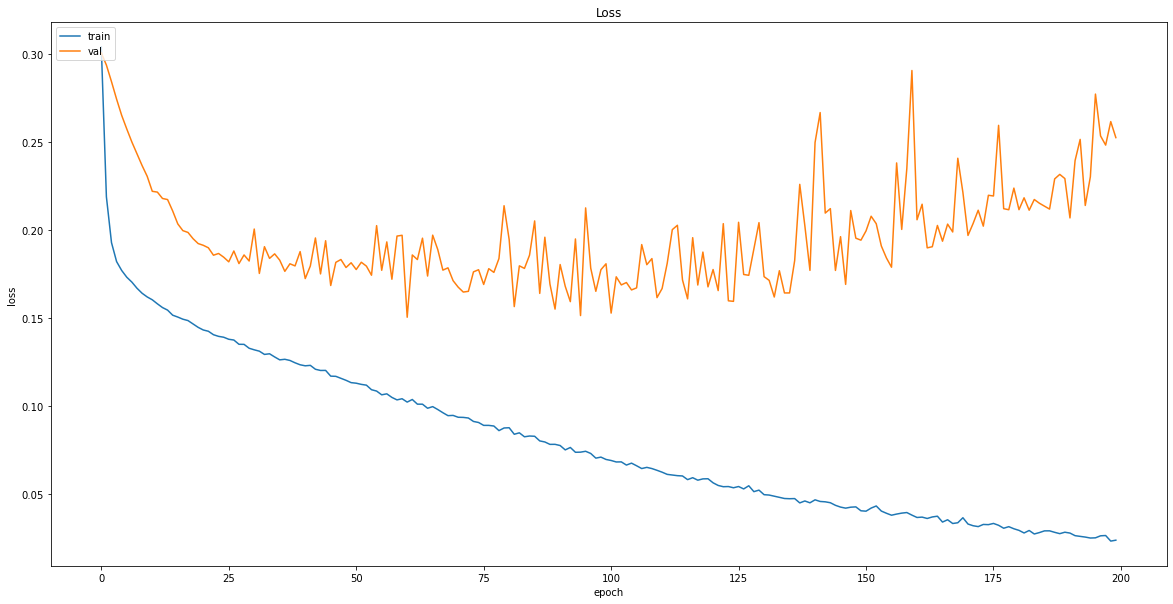

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_original.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [32]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [33]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [34]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(207, 15, 4)

In [35]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [36]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2062 - accuracy: 0.7440 - mean_squared_error: 10.8747 - weighted_accuracy: 0.7440 - weighted_mean_squared_error: 10.8747
Test loss: 0.20622892677783966
Test accuracy: 0.7439613342285156


In [37]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 164, 1: 13, 0: 30})

In [38]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [39]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [40]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-15,724.780029,700.682442,-8.071529,46243699.0,2.0,2,2
2019-02-18,740.000000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.760010,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.000000,713.082376,-17.677836,44744340.0,2.0,1,2
2019-02-21,720.250000,714.454318,-29.824573,40956103.0,2.0,1,2


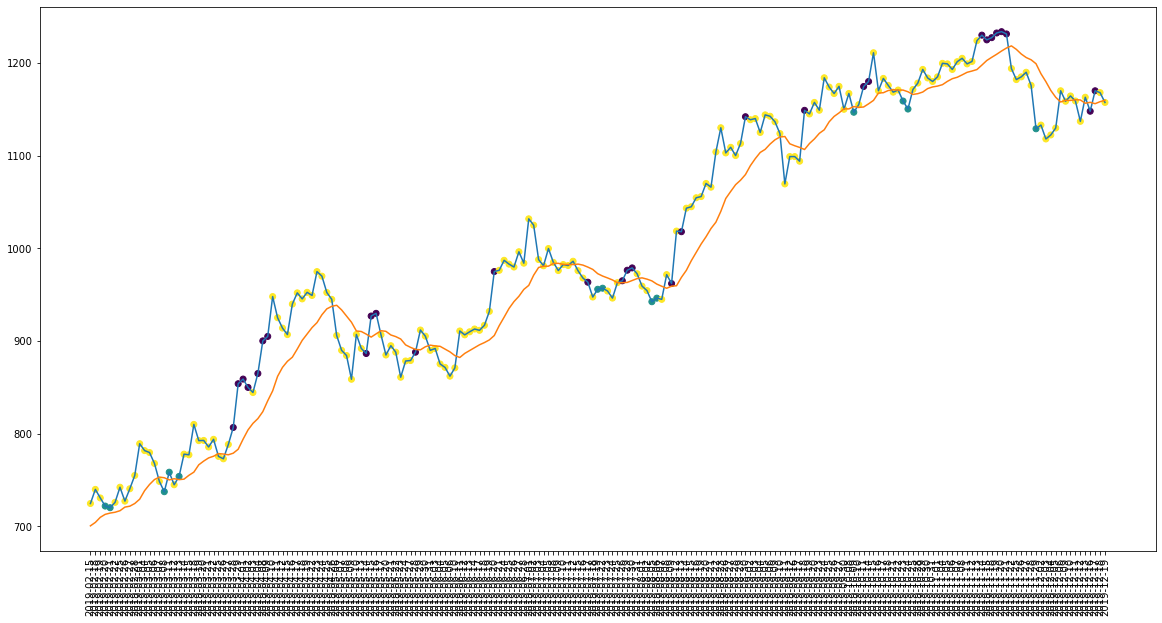

In [41]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [42]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 12
actual holds but predicted sell: 25
actual predicted holds: 148
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 80.0%
actual buys: 11
actual sells: 11
actual holds: 185


In [43]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 724.780029296875, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438]
[727.3499755859375, 740.7000122070312, 742.3300170898438, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 84.61538461538461%
Percentage sells correct: 53.333333333333336%
Percentage holds correct: 87.1951219512195%


In [44]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 724.780029296875, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438]
[727.3499755859375, 740.7000122070312, 742.3300170898438, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 84.61538461538461%
Percentage sells correct: 53.333333333333336%
Percentage holds correct: 87.1951219512195%


In [45]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $722.0
Shares owned at the moment: 13
Cash capital at the moment: $588.1885000000002


Price increase from previously bought: 11.43869425464581%
Share price: $806.7999877929688
Shares owned at the moment: 0
Cash capital at the moment: $11047.745241744995


Share price: $955.8699951171876
Shares owned at the moment: 11
Cash capital at the moment: $504.2602281036361


Price increase from previously bought: 6.202551810808976%
Share price: $1017.9500122070312
Shares owned at the moment: 0
Cash capital at the moment: $11670.917374511717


Share price: $1146.81005859375
Shares owned at the moment: 10
Cash capital at the moment: $171.27951196288814


Price increase from previously bought: 6.959889928862317%
Share price: $1230.0
Shares owned at the moment: 0
Cash capital at the moment: $12437.454511962887


Share price: $1129.0
Shares owned at the moment: 10
Cash capital at the moment: $1116.4070119628868




Capital at the end of test period: $12658.578755432125
profit gained: 26

In [46]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15556.77199960327
profit gained: 55.56771999603271%


### Recession

In [47]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [48]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [49]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [50]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [51]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.7356 - mean_squared_error: 9.7687 - weighted_accuracy: 0.7356 - weighted_mean_squared_error: 9.7687
Test loss: 0.20554938912391663
Test accuracy: 0.7355769276618958


In [52]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 165, 1: 6, 0: 37})

In [53]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [54]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [55]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-18,1084.000000,1082.243470,-14.989967,2243205.0,2.0,2,2
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,0
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,2
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2


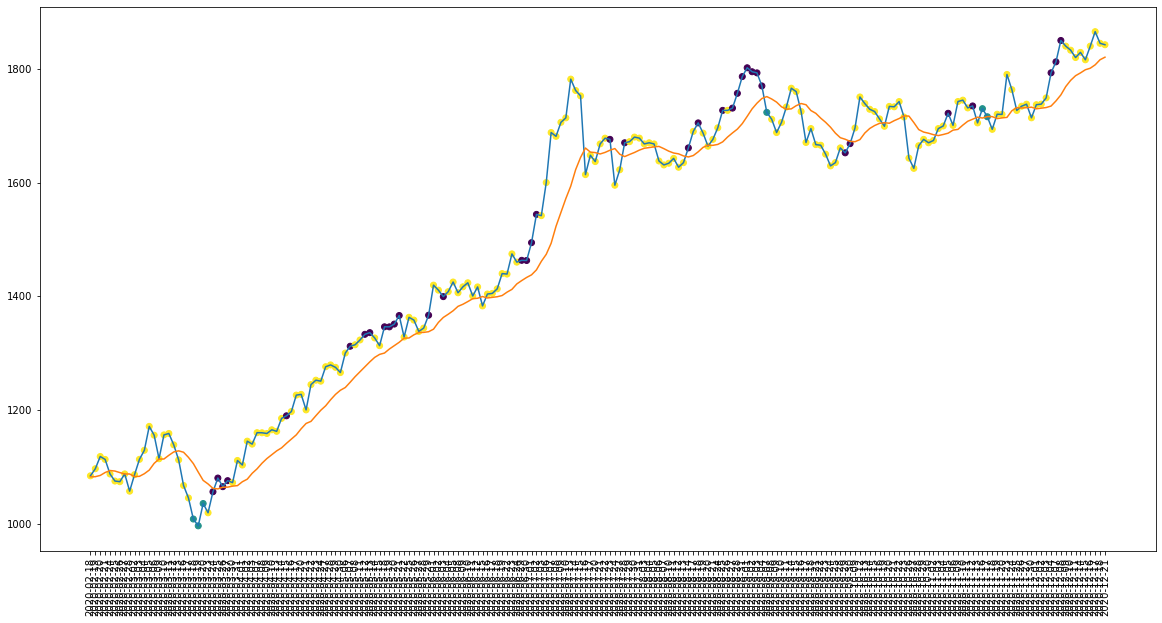

In [56]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [57]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 4
actual holds but predicted sell: 35
actual predicted holds: 150
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 10.0%
Percentage holds correct: 79.36507936507937%
actual buys: 9
actual sells: 10
actual holds: 189


In [58]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1084.0, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1073.699951171875, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1171.0]
Percentage buys correct: 83.33333333333333%
Percentage sells correct: 45.945945945945944%
Percentage holds correct: 84.24242424242425%


In [59]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1007.989990234375
Shares owned at the moment: 9
Cash capital at the moment: $903.1423356323248


Price increase from previously bought: 6.859974498118526%
Share price: $1080.0999755859377
Shares owned at the moment: 0
Cash capital at the moment: $10597.309641510012


Share price: $1723.5
Shares owned at the moment: 6
Cash capital at the moment: $227.87189151001076


Stop Loss Activated!

Share price: $1670.52001953125
Shares owned at the moment: 0
Cash capital at the moment: $10223.428428375244


Share price: $1730.050048828125
Shares owned at the moment: 5
Cash capital at the moment: $1549.3899960632316


Price increase from previously bought: 6.64006243668982%
Share price: $1850.0
Shares owned at the moment: 0
Cash capital at the moment: $10773.952496063232




Capital at the end of test period: $10773.952496063232
profit gained: 7.739524960632316%


In [60]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16754.069125
profit gained: 67.54069125000002%


### Midea Group

In [61]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [62]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [63]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [64]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(1253, 15, 4)

In [65]:
y = labels
y = np.array(y)

In [66]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [67]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [68]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [70]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
8/8 [==============================] - 1s 93ms/step - loss: 0.3468 - accuracy: 0.5439 - mse: 0.3402 - weighted_accuracy: 0.2994 - weighted_mse: 0.4501 - val_loss: 0.3029 - val_accuracy: 0.0677 - val_mse: 0.3395 - val_weighted_accuracy: 0.0677 - val_weighted_mse: 0.3395
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2853 - accuracy: 0.5449 - mse: 0.4011 - weighted_accuracy: 0.3406 - weighted_mse: 0.4749 - val_loss: 0.3028 - val_accuracy: 0.0518 - val_mse: 0.3463 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.3463
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2528 - accuracy: 0.5230 - mse: 0.4816 - weighted_accuracy: 0.4265 - weighted_mse: 0.5258 - val_loss: 0.3013 - val_accuracy: 0.0478 - val_mse: 0.3494 - val_weighted_accuracy: 0.0478 - val_weighted_mse: 0.3494
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2283 - accuracy: 0.4810 - mse: 0.5652 - weighted_accuracy: 0.4683 - weighted_mse: 0

8/8 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.4750 - mse: 1.2947 - weighted_accuracy: 0.7579 - weighted_mse: 1.2418 - val_loss: 0.2419 - val_accuracy: 0.0518 - val_mse: 0.7534 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7534
Epoch 31/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1369 - accuracy: 0.4681 - mse: 1.3036 - weighted_accuracy: 0.7694 - weighted_mse: 1.2531 - val_loss: 0.2408 - val_accuracy: 0.0518 - val_mse: 0.7766 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7766
Epoch 32/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1358 - accuracy: 0.4940 - mse: 1.3087 - weighted_accuracy: 0.7853 - weighted_mse: 1.2682 - val_loss: 0.2404 - val_accuracy: 0.0518 - val_mse: 0.8042 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.8042
Epoch 33/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1341 - accuracy: 0.4721 - mse: 1.3201 - weighted_accuracy: 0.7709 - weighted_mse: 1.2748 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.1066 - accuracy: 0.5998 - mse: 1.5273 - weighted_accuracy: 0.8393 - weighted_mse: 1.5101 - val_loss: 0.2161 - val_accuracy: 0.2629 - val_mse: 1.4619 - val_weighted_accuracy: 0.2629 - val_weighted_mse: 1.4619
Epoch 60/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1055 - accuracy: 0.6297 - mse: 1.5277 - weighted_accuracy: 0.8427 - weighted_mse: 1.5201 - val_loss: 0.2207 - val_accuracy: 0.2112 - val_mse: 1.4955 - val_weighted_accuracy: 0.2112 - val_weighted_mse: 1.4955
Epoch 61/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1029 - accuracy: 0.6158 - mse: 1.5341 - weighted_accuracy: 0.8376 - weighted_mse: 1.5285 - val_loss: 0.2169 - val_accuracy: 0.2629 - val_mse: 1.4878 - val_weighted_accuracy: 0.2629 - val_weighted_mse: 1.4878
Epoch 62/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1050 - accuracy: 0.6337 - mse: 1.5324 - weighted_accuracy: 0.8366 - weighted_mse: 1.5236 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0783 - accuracy: 0.7505 - mse: 1.8824 - weighted_accuracy: 0.8945 - weighted_mse: 1.9387 - val_loss: 0.1518 - val_accuracy: 0.6335 - val_mse: 1.8517 - val_weighted_accuracy: 0.6335 - val_weighted_mse: 1.8517
Epoch 89/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0792 - accuracy: 0.7545 - mse: 1.8895 - weighted_accuracy: 0.8960 - weighted_mse: 1.9118 - val_loss: 0.1499 - val_accuracy: 0.6614 - val_mse: 1.8659 - val_weighted_accuracy: 0.6614 - val_weighted_mse: 1.8659
Epoch 90/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0781 - accuracy: 0.7685 - mse: 1.8879 - weighted_accuracy: 0.9087 - weighted_mse: 1.9164 - val_loss: 0.1558 - val_accuracy: 0.6454 - val_mse: 1.9175 - val_weighted_accuracy: 0.6454 - val_weighted_mse: 1.9175
Epoch 91/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0762 - accuracy: 0.7605 - mse: 1.9089 - weighted_accuracy: 0.9057 - weighted_mse: 1.9380 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.0562 - accuracy: 0.8343 - mse: 2.5028 - weighted_accuracy: 0.9328 - weighted_mse: 2.5346 - val_loss: 0.1550 - val_accuracy: 0.7490 - val_mse: 2.7768 - val_weighted_accuracy: 0.7490 - val_weighted_mse: 2.7768
Epoch 118/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.8443 - mse: 2.5187 - weighted_accuracy: 0.9429 - weighted_mse: 2.5208 - val_loss: 0.1579 - val_accuracy: 0.7450 - val_mse: 2.8353 - val_weighted_accuracy: 0.7450 - val_weighted_mse: 2.8353
Epoch 119/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0536 - accuracy: 0.8433 - mse: 2.5288 - weighted_accuracy: 0.9426 - weighted_mse: 2.5565 - val_loss: 0.1538 - val_accuracy: 0.7729 - val_mse: 2.8043 - val_weighted_accuracy: 0.7729 - val_weighted_mse: 2.8043
Epoch 120/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0548 - accuracy: 0.8543 - mse: 2.5612 - weighted_accuracy: 0.9466 - weighted_mse: 2.5522 -

Epoch 146/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0383 - accuracy: 0.9062 - mse: 3.4188 - weighted_accuracy: 0.9656 - weighted_mse: 3.3095 - val_loss: 0.1719 - val_accuracy: 0.7968 - val_mse: 3.9149 - val_weighted_accuracy: 0.7968 - val_weighted_mse: 3.9149
Epoch 147/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0385 - accuracy: 0.9052 - mse: 3.4642 - weighted_accuracy: 0.9652 - weighted_mse: 3.3365 - val_loss: 0.1737 - val_accuracy: 0.7809 - val_mse: 3.8831 - val_weighted_accuracy: 0.7809 - val_weighted_mse: 3.8831
Epoch 148/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0373 - accuracy: 0.9092 - mse: 3.5054 - weighted_accuracy: 0.9667 - weighted_mse: 3.3556 - val_loss: 0.1708 - val_accuracy: 0.8127 - val_mse: 4.0734 - val_weighted_accuracy: 0.8127 - val_weighted_mse: 4.0734
Epoch 149/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9122 - mse: 3.5368 - weighted_accuracy: 0.9678 - weighted

Epoch 175/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9291 - mse: 4.5978 - weighted_accuracy: 0.9740 - weighted_mse: 4.1959 - val_loss: 0.2161 - val_accuracy: 0.8088 - val_mse: 5.3134 - val_weighted_accuracy: 0.8088 - val_weighted_mse: 5.3134
Epoch 176/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0274 - accuracy: 0.9361 - mse: 4.6512 - weighted_accuracy: 0.9766 - weighted_mse: 4.2659 - val_loss: 0.2175 - val_accuracy: 0.7530 - val_mse: 5.1012 - val_weighted_accuracy: 0.7530 - val_weighted_mse: 5.1012
Epoch 177/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0269 - accuracy: 0.9351 - mse: 4.7096 - weighted_accuracy: 0.9762 - weighted_mse: 4.2947 - val_loss: 0.2038 - val_accuracy: 0.8446 - val_mse: 5.6526 - val_weighted_accuracy: 0.8446 - val_weighted_mse: 5.6526
Epoch 178/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9381 - mse: 4.7862 - weighted_accuracy: 0.9773 - weighted

In [71]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2292468547821045
Test accuracy: 0.7848605513572693


In [72]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.1035094e+00 -2.6954556e+00  2.5860376e+00]
 [ 1.6258179e-01 -2.5172727e+00 -1.1073632e+00]
 [-3.0539067e+00 -1.5574048e+00  1.5353229e+00]
 [-1.7062620e+00 -6.5145832e-01 -9.0722936e-01]
 [-2.0030518e+00 -1.3840556e+00  3.9984387e-01]
 [-2.7276528e-01 -2.4894900e+00 -6.5244907e-01]
 [-5.4167395e+00 -3.0798559e+00  3.0248084e+00]
 [ 2.8454145e-02 -2.6060839e+00 -1.3281338e+00]
 [-1.5028727e+00 -2.4391127e+00  4.6271452e-01]
 [-1.1946144e+00 -3.4773462e+00  9.1811651e-01]
 [-2.6358576e+00 -3.3907132e+00  2.0295041e+00]
 [-6.4724076e-01 -3.0103798e+00  1.3513526e-01]
 [-1.9708719e+00 -3.2065601e+00  1.6897250e+00]
 [-6.3670478e+00 -5.3409042e+00  4.6056161e+00]
 [-1.2653409e+00 -5.0579877e+00  1.7632601e+00]
 [-6.3834924e-01 -4.3330407e+00 -2.3804316e-01]
 [-2.7541111e+00 -8.5920364e-01  5.8497232e-01]
 [-8.3960730e-01 -2.9052215e+00  7.2772451e-02]
 [-3.8712862e+00 -2.7403135e+00  2.7881706e+00]
 [-1.5893739e+00 -2.8934875e+00  8.7658304e-01]
 [-2.5301721e+00 -3.4348512e+00  1.86922

Counter({2: 219, 0: 16, 1: 16})

In [73]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [74]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 251
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 15
actual predicted holds: 197
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 86.40350877192982%
actual buys: 13
actual sells: 10
actual holds: 228


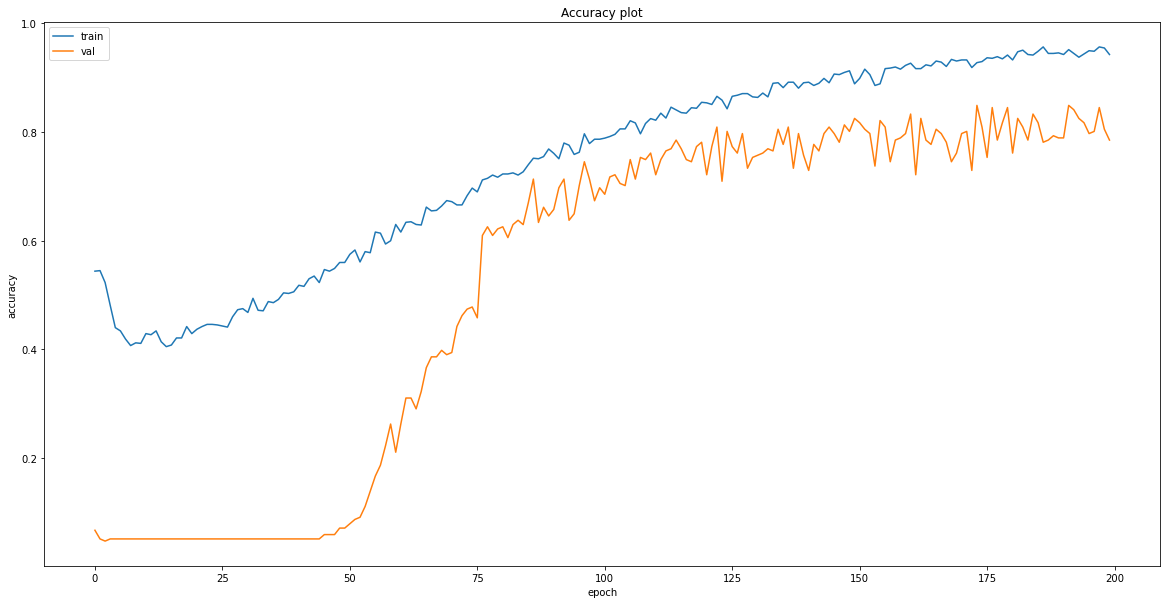

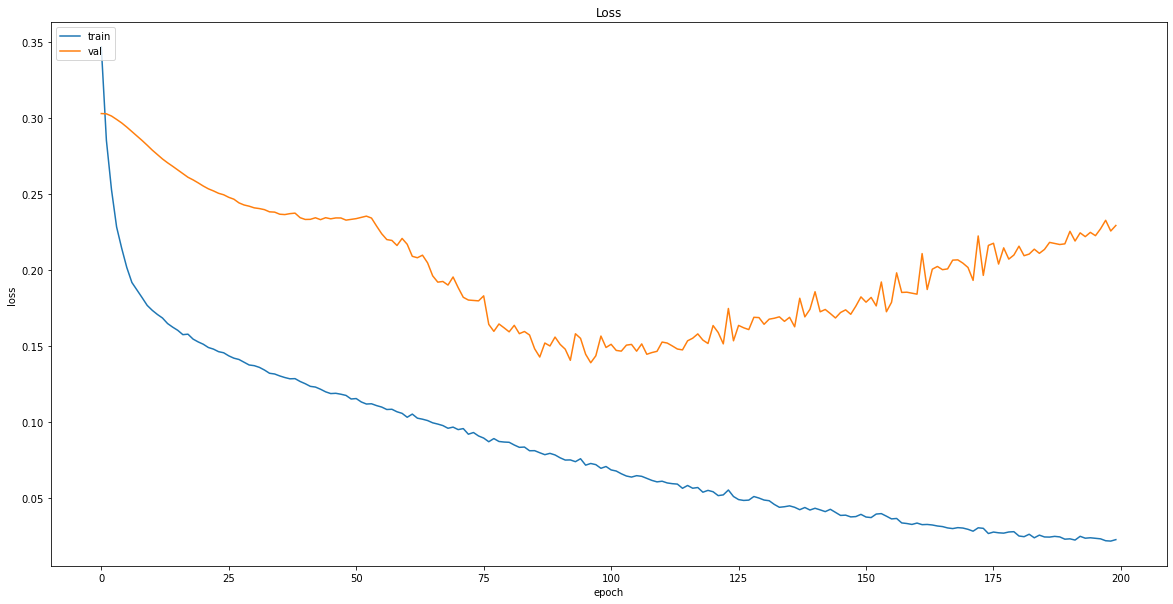

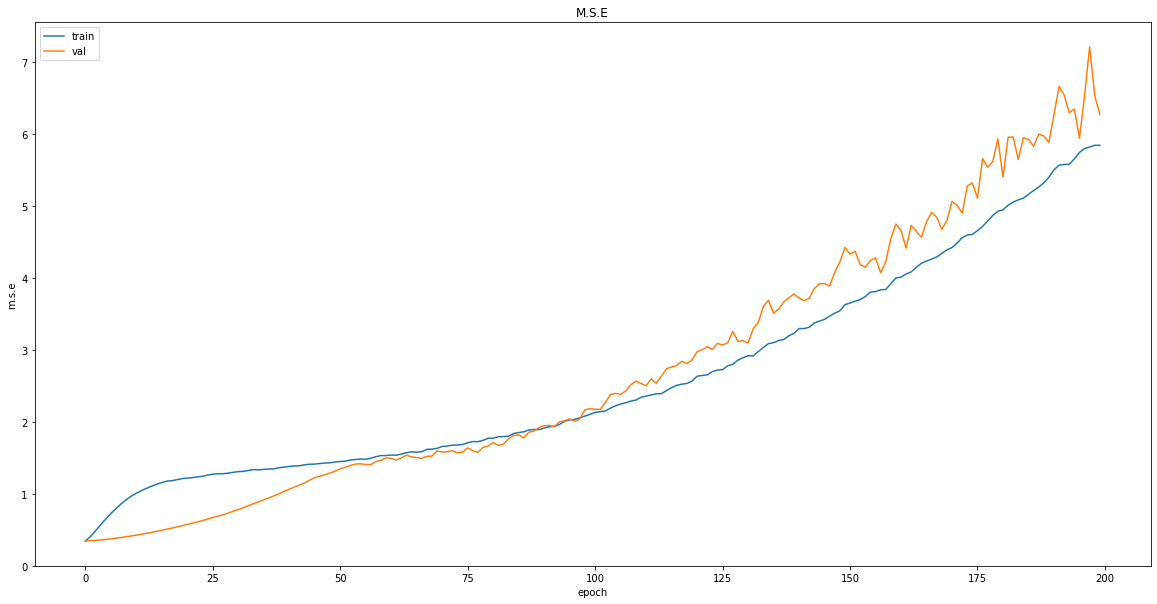

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [77]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


In [78]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [79]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(207, 15, 4)

In [80]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [83]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1657 - accuracy: 0.8164 - mean_squared_error: 5.6310 - weighted_accuracy: 0.8164 - weighted_mean_squared_error: 5.6310
Test loss: 0.1656537801027298
Test accuracy: 0.8164251446723938


In [84]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 185, 1: 11, 0: 11})

In [85]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [86]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [87]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,1,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,1,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,1,2


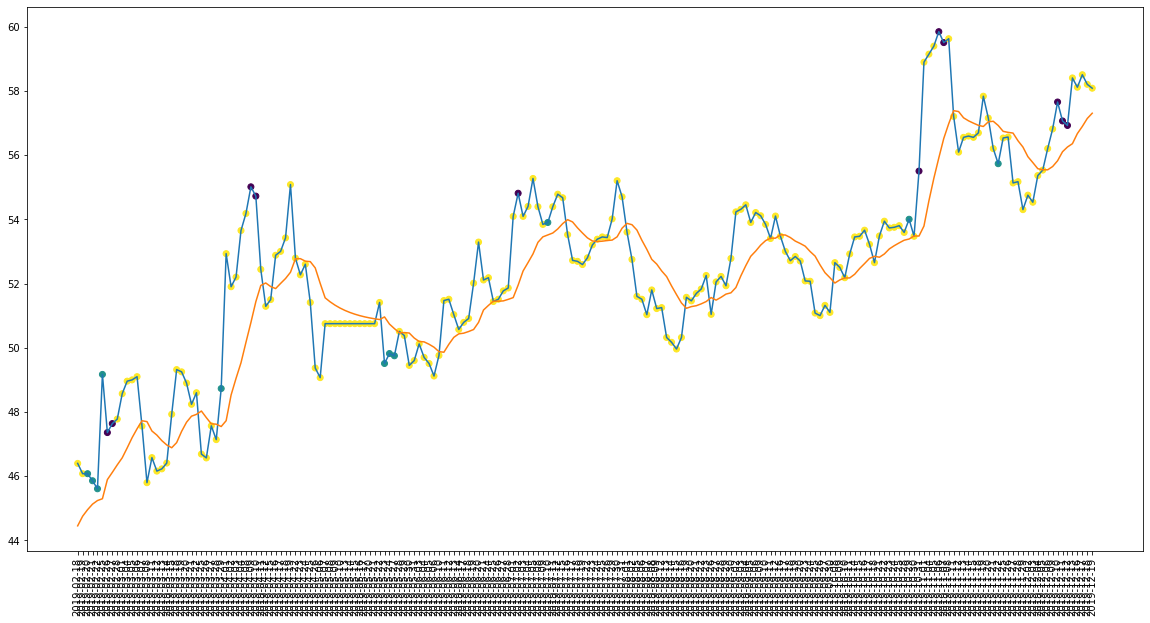

In [88]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

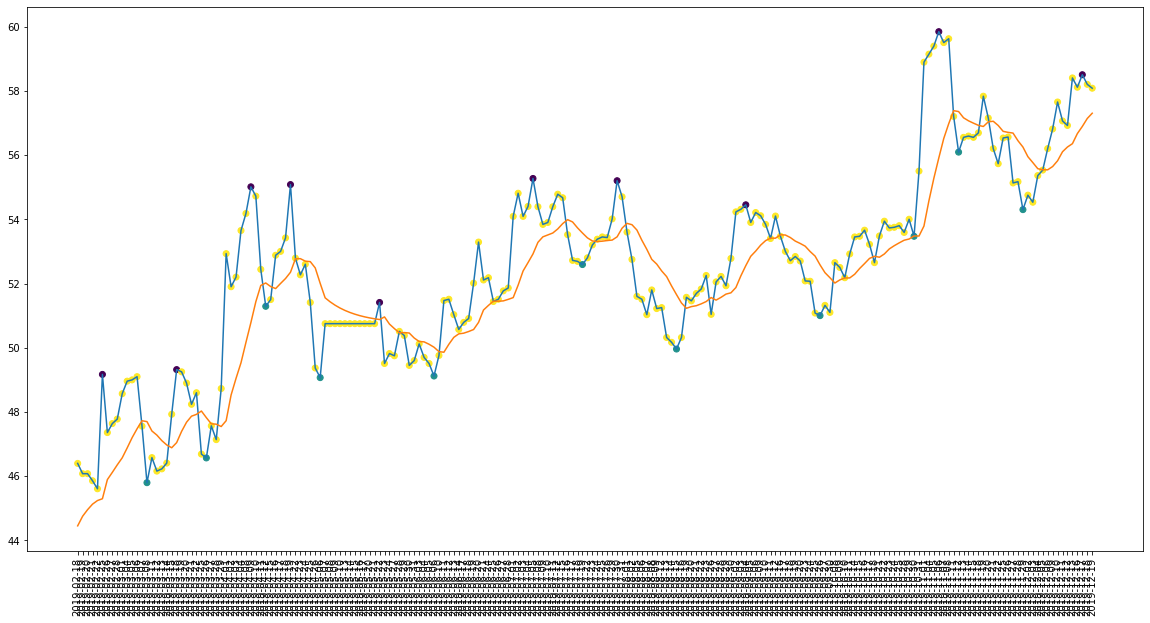

In [89]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [90]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 10
actual holds but predicted sell: 9
actual predicted holds: 167
Percentage buys correct: 0.0%
Percentage sells correct: 20.0%
Percentage holds correct: 89.78494623655914%
actual buys: 11
actual sells: 10
actual holds: 186


In [91]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 79.8913043478261%


In [92]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.08000183105469
Shares owned at the moment: 216
Cash capital at the moment: $19.348083404540375


Price increase from previously bought: 19.05193905915059%
Share price: $55.0099983215332
Shares owned at the moment: 0
Cash capital at the moment: $11868.831781852721


Share price: $49.5099983215332
Shares owned at the moment: 239
Cash capital at the moment: $3.4017366094576573


Price increase from previously bought: 10.401311020901893%
Share price: $54.81000137329102
Shares owned at the moment: 0
Cash capital at the moment: $13066.968191423417


Share price: $53.9000015258789
Shares owned at the moment: 241
Cash capital at the moment: $41.345597675326644


Stop Loss Activated!

Share price: $51.599998474121094
Shares owned at the moment: 0
Cash capital at the moment: $12442.747330949785


Share price: $54.0
Shares owned at the moment: 229
Cash capital at the moment: $42.74083094978596


Price increase from previously bought: 10.51091009462477%
Share price: $59.8400001525

In [93]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


### recession

In [94]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


In [95]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [96]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [97]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [99]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2150 - accuracy: 0.6923 - mean_squared_error: 5.4156 - weighted_accuracy: 0.6923 - weighted_mean_squared_error: 5.4156
Test loss: 0.2150411754846573
Test accuracy: 0.692307710647583


In [100]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 154, 0: 25, 1: 29})

In [101]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [102]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,0,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,2,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


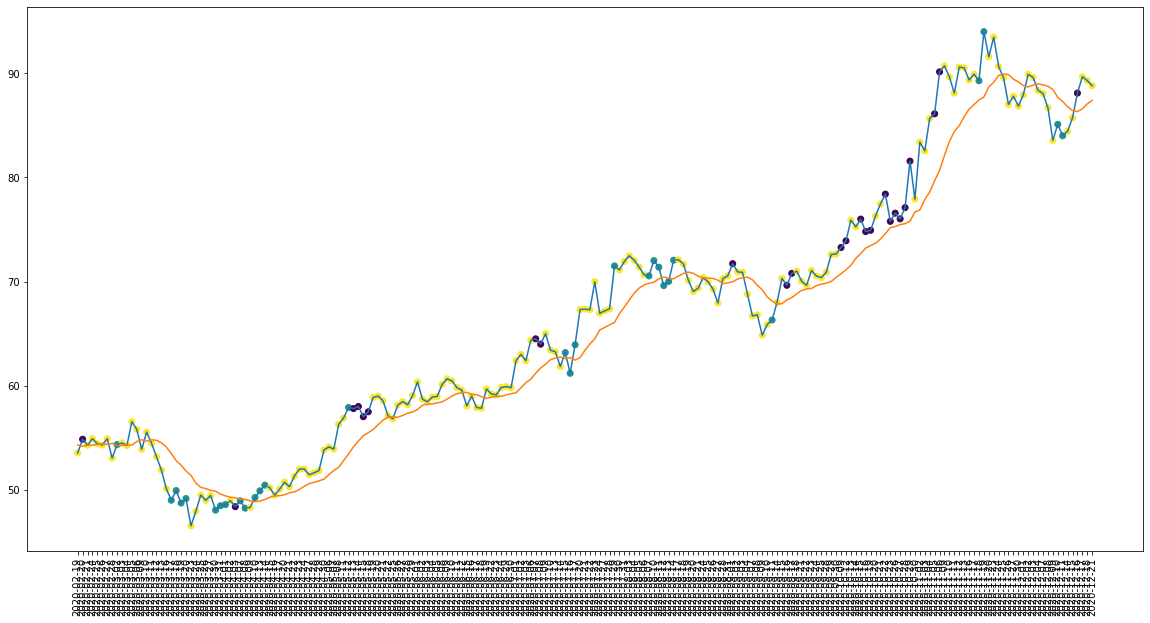

In [104]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

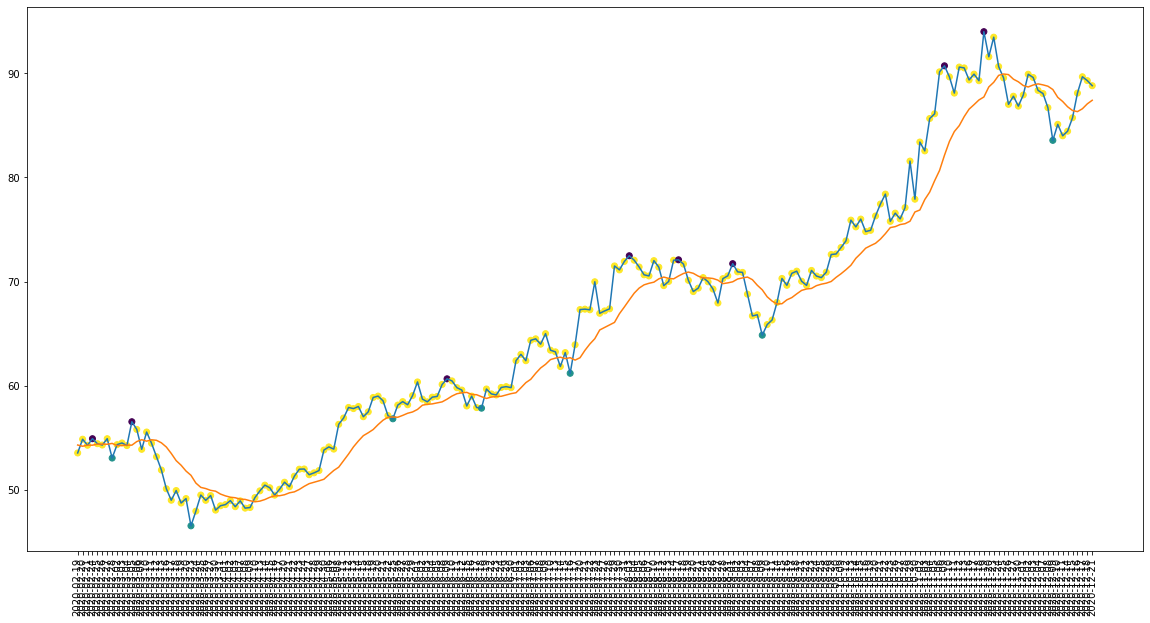

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [106]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 27
actual holds but predicted sell: 24
actual predicted holds: 142
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 12.5%
Percentage holds correct: 73.57512953367876%
actual buys: 7
actual sells: 8
actual holds: 193


In [107]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 51.724137931034484%
Percentage sells correct: 48.0%
Percentage holds correct: 84.9673202614379%


In [108]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.34000015258789
Shares owned at the moment: 183
Cash capital at the moment: $28.43336699962674


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9500.014970467566


Share price: $49.0
Shares owned at the moment: 193
Cash capital at the moment: $17.00822046756548


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8974.527291678427


Share price: $48.04999923706055
Shares owned at the moment: 186
Cash capital at the moment: $12.649858975408279


Price increase from previously bought: 19.96146944458581%
Share price: $57.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10733.885017458913


Share price: $63.18000030517578
Shares owned at the moment: 169
Cash capital at the moment: $27.102060742376125


Stop Loss Activated!

Share price: $61.18999862670898
Shares owned at the moment: 0
Cash capital at the moment: $10339.7737

In [109]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [110]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


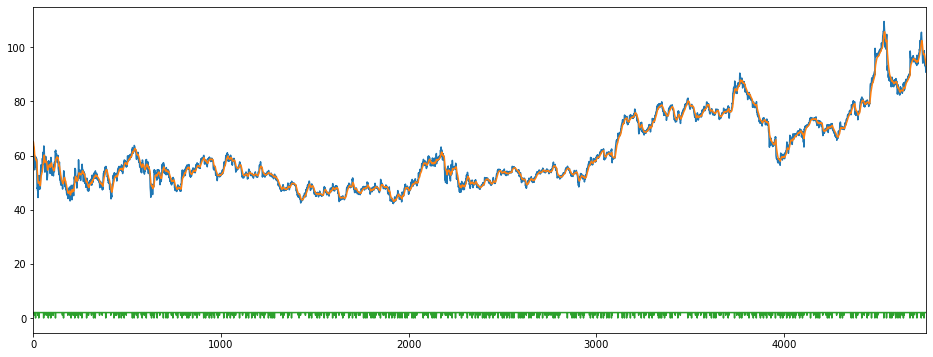

In [111]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [112]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [113]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [114]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [115]:
y = labels
y = np.array(y)

In [116]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [117]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [118]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [119]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [120]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2905 - accuracy: 0.4960 - mse: 0.4680 - weighted_accuracy: 0.3135 - weighted_mse: 0.5440 - val_loss: 0.2996 - val_accuracy: 0.0453 - val_mse: 0.3552 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3552
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2098 - accuracy: 0.3319 - mse: 0.8136 - weighted_accuracy: 0.4251 - weighted_mse: 0.7951 - val_loss: 0.2905 - val_accuracy: 0.0453 - val_mse: 0.3832 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3832
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1895 - accuracy: 0.3182 - mse: 1.0300 - weighted_accuracy: 0.4755 - weighted_mse: 1.0133 - val_loss: 0.2802 - val_accuracy: 0.0453 - val_mse: 0.4209 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4209
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1831 - accuracy: 0.3016 - mse: 1.1684 - weighted_accuracy: 0.5004 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1324 - accuracy: 0.4120 - mse: 1.6939 - weighted_accuracy: 0.7300 - weighted_mse: 1.6154 - val_loss: 0.1842 - val_accuracy: 0.4110 - val_mse: 1.7037 - val_weighted_accuracy: 0.4110 - val_weighted_mse: 1.7037
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1311 - accuracy: 0.4139 - mse: 1.7264 - weighted_accuracy: 0.7378 - weighted_mse: 1.6502 - val_loss: 0.1878 - val_accuracy: 0.3530 - val_mse: 1.7198 - val_weighted_accuracy: 0.3530 - val_weighted_mse: 1.7198
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1296 - accuracy: 0.4560 - mse: 1.7321 - weighted_accuracy: 0.7498 - weighted_mse: 1.6587 - val_loss: 0.1930 - val_accuracy: 0.3467 - val_mse: 1.7518 - val_weighted_accuracy: 0.3467 - val_weighted_mse: 1.7518
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1294 - accuracy: 0.4355 - mse: 1.7498 - weighted_accuracy: 0.7546 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1046 - accuracy: 0.6270 - mse: 2.3428 - weighted_accuracy: 0.8396 - weighted_mse: 2.3118 - val_loss: 0.2017 - val_accuracy: 0.4521 - val_mse: 2.5725 - val_weighted_accuracy: 0.4521 - val_weighted_mse: 2.5725
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1043 - accuracy: 0.6183 - mse: 2.3843 - weighted_accuracy: 0.8273 - weighted_mse: 2.3706 - val_loss: 0.1883 - val_accuracy: 0.4816 - val_mse: 2.5076 - val_weighted_accuracy: 0.4816 - val_weighted_mse: 2.5076
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1029 - accuracy: 0.5985 - mse: 2.3993 - weighted_accuracy: 0.8274 - weighted_mse: 2.3695 - val_loss: 0.1723 - val_accuracy: 0.5564 - val_mse: 2.5387 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 2.5387
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1014 - accuracy: 0.6135 - mse: 2.4142 - weighted_accuracy: 0.8328 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0793 - accuracy: 0.7255 - mse: 3.2999 - weighted_accuracy: 0.8921 - weighted_mse: 3.2814 - val_loss: 0.1617 - val_accuracy: 0.6639 - val_mse: 3.3757 - val_weighted_accuracy: 0.6639 - val_weighted_mse: 3.3757
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0797 - accuracy: 0.7439 - mse: 3.3565 - weighted_accuracy: 0.8915 - weighted_mse: 3.3391 - val_loss: 0.2094 - val_accuracy: 0.5090 - val_mse: 3.4563 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 3.4563
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0811 - accuracy: 0.7136 - mse: 3.3477 - weighted_accuracy: 0.8822 - weighted_mse: 3.3108 - val_loss: 0.1943 - val_accuracy: 0.5711 - val_mse: 3.5324 - val_weighted_accuracy: 0.5711 - val_weighted_mse: 3.5324
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0782 - accuracy: 0.7424 - mse: 3.4410 - weighted_accuracy: 0.8909 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0630 - accuracy: 0.8035 - mse: 4.6613 - weighted_accuracy: 0.9187 - weighted_mse: 4.5414 - val_loss: 0.1763 - val_accuracy: 0.6786 - val_mse: 4.7730 - val_weighted_accuracy: 0.6786 - val_weighted_mse: 4.7730
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0589 - accuracy: 0.8124 - mse: 4.6363 - weighted_accuracy: 0.9239 - weighted_mse: 4.5365 - val_loss: 0.1976 - val_accuracy: 0.6312 - val_mse: 4.8626 - val_weighted_accuracy: 0.6312 - val_weighted_mse: 4.8626
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0579 - accuracy: 0.8232 - mse: 4.8287 - weighted_accuracy: 0.9333 - weighted_mse: 4.6634 - val_loss: 0.1771 - val_accuracy: 0.7050 - val_mse: 4.9072 - val_weighted_accuracy: 0.7050 - val_weighted_mse: 4.9072
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0592 - accuracy: 0.8082 - mse: 4.7893 - weighted_accuracy: 0.9224 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0450 - accuracy: 0.8699 - mse: 6.6694 - weighted_accuracy: 0.9412 - weighted_mse: 6.2560 - val_loss: 0.2546 - val_accuracy: 0.6017 - val_mse: 6.2941 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 6.2941
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.8688 - mse: 6.4968 - weighted_accuracy: 0.9518 - weighted_mse: 6.0539 - val_loss: 0.1952 - val_accuracy: 0.7555 - val_mse: 7.3324 - val_weighted_accuracy: 0.7555 - val_weighted_mse: 7.3324
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0467 - accuracy: 0.8691 - mse: 6.6193 - weighted_accuracy: 0.9447 - weighted_mse: 6.2032 - val_loss: 0.2124 - val_accuracy: 0.7176 - val_mse: 7.2662 - val_weighted_accuracy: 0.7176 - val_weighted_mse: 7.2662
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.8746 - mse: 6.6659 - weighted_accuracy: 0.9521 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.9099 - mse: 8.8302 - weighted_accuracy: 0.9669 - weighted_mse: 8.0918 - val_loss: 0.2356 - val_accuracy: 0.7471 - val_mse: 9.6265 - val_weighted_accuracy: 0.7471 - val_weighted_mse: 9.6265
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9146 - mse: 8.9833 - weighted_accuracy: 0.9668 - weighted_mse: 8.2290 - val_loss: 0.2377 - val_accuracy: 0.7176 - val_mse: 9.2396 - val_weighted_accuracy: 0.7176 - val_weighted_mse: 9.2396
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 0.9096 - mse: 8.9077 - weighted_accuracy: 0.9633 - weighted_mse: 8.1742 - val_loss: 0.2618 - val_accuracy: 0.6797 - val_mse: 8.5634 - val_weighted_accuracy: 0.6797 - val_weighted_mse: 8.5634
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9123 - mse: 9.1330 - weighted_accuracy: 0.9605 - 

In [121]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25716421008110046
Test accuracy: 0.7766069769859314


In [122]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.8660645  -4.709801    3.2034185 ]
 [-3.3448794  -2.226221    1.3770142 ]
 [-0.09991515 -2.8671885  -1.0802014 ]
 ...
 [-8.795671    0.7748647  -1.0180557 ]
 [-4.0554094  -4.6456003   3.0157351 ]
 [-3.549549   -5.5858893   3.121564  ]]


Counter({2: 818, 0: 54, 1: 77})

In [123]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [124]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 41
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 42
actual holds but predicted buy: 73
actual holds but predicted sell: 54
actual predicted holds: 735
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 0.0%
Percentage holds correct: 85.26682134570765%
actual buys: 43
actual sells: 44
actual holds: 862


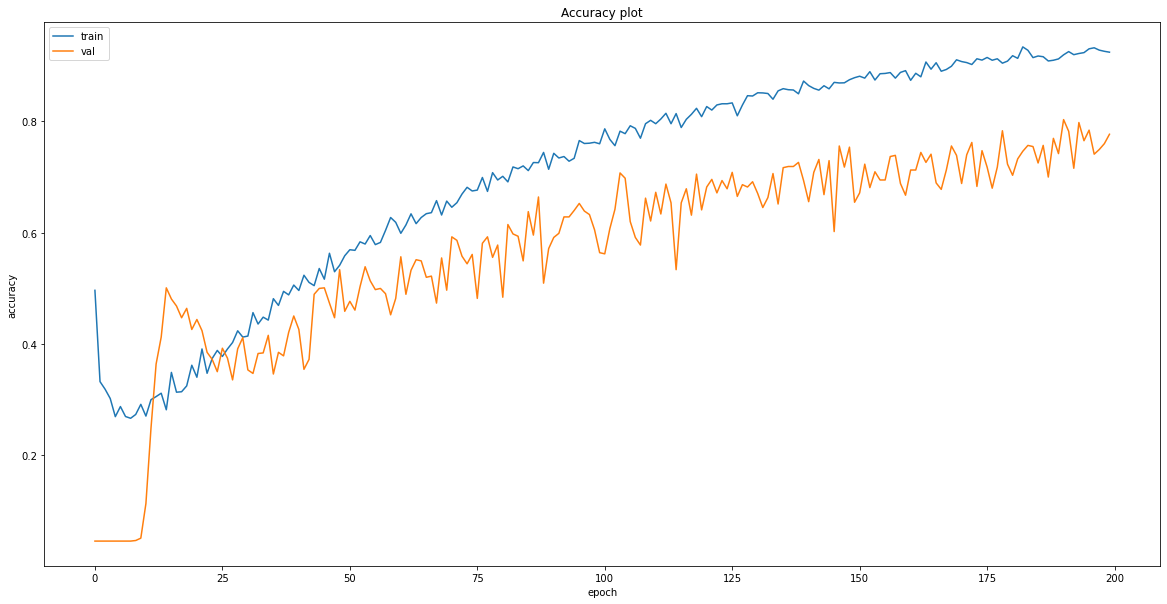

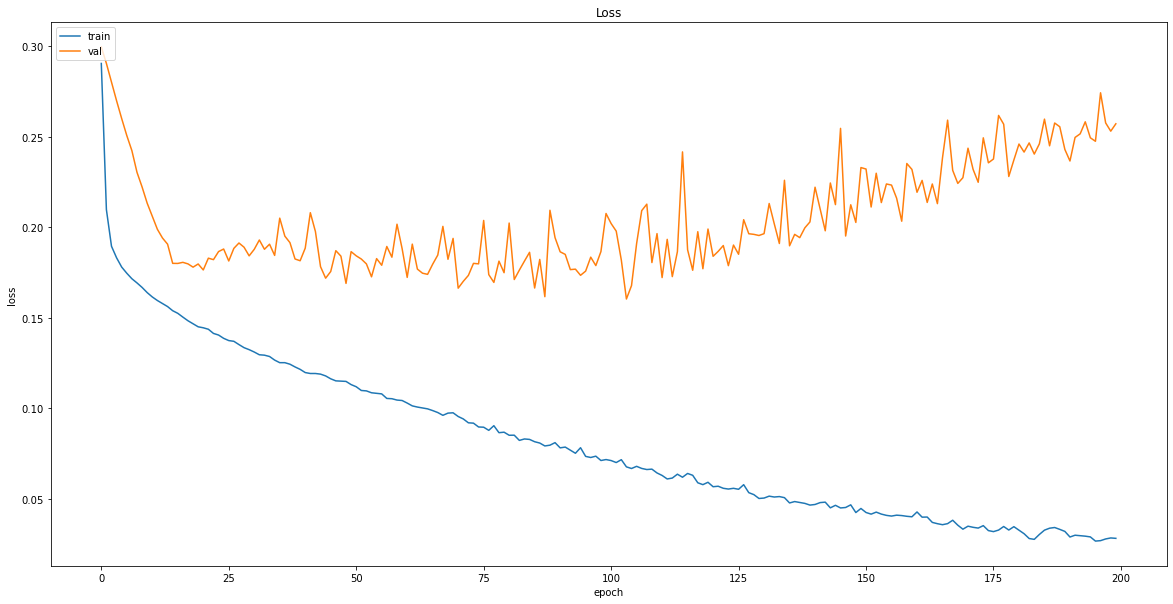

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [126]:
# Save model
model.save("models/{}".format('wmt_time_series_lstm_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/wmt_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [127]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [128]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [129]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [130]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.7798 - mean_squared_error: 10.3512 - weighted_accuracy: 0.7798 - weighted_mean_squared_error: 10.3512
Test loss: 0.18408717215061188
Test accuracy: 0.7798165082931519


In [131]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 0: 20, 1: 18})

In [132]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [133]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [134]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


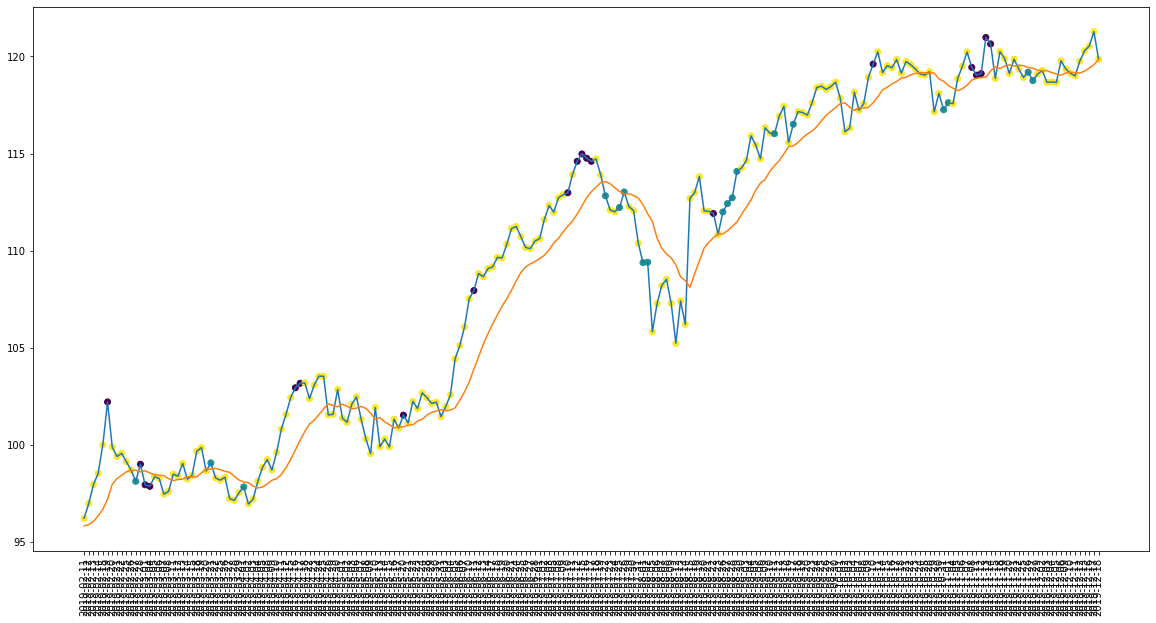

In [135]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

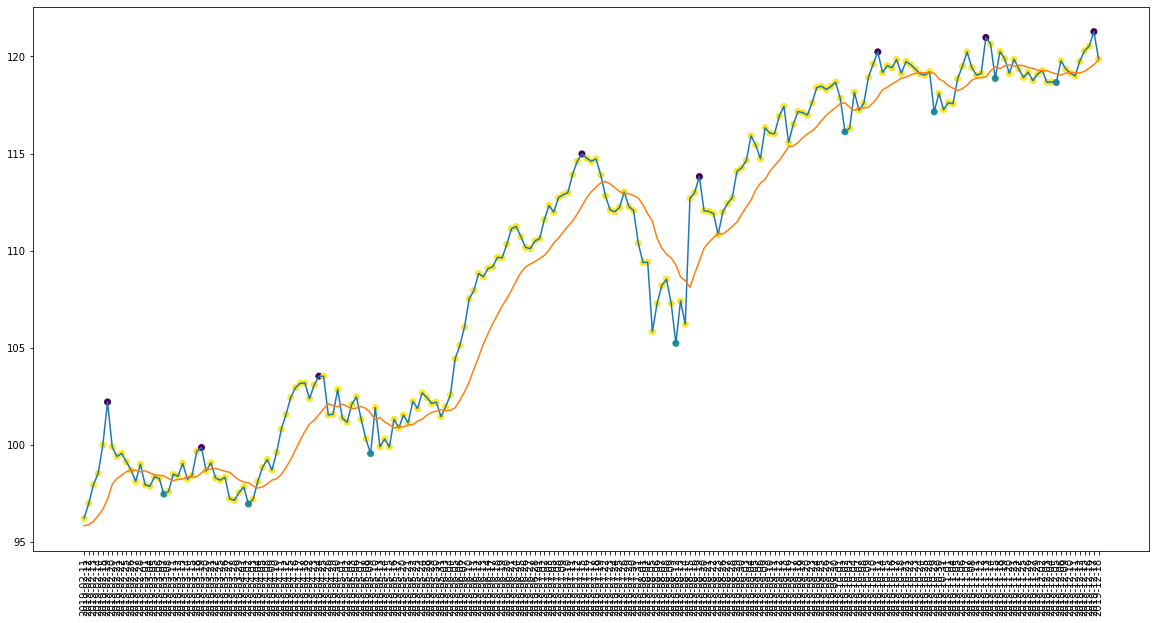

In [136]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [137]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 18
actual holds but predicted sell: 17
actual predicted holds: 167
Percentage buys correct: 0.0%
Percentage sells correct: 37.5%
Percentage holds correct: 82.67326732673267%
actual buys: 8
actual sells: 8
actual holds: 202


In [138]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 50.0%
Percentage sells correct: 60.0%
Percentage holds correct: 84.91620111731844%


In [139]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.11000061035156
Shares owned at the moment: 101
Cash capital at the moment: $63.63988568496643


Price increase from previously bought: 9.717644299907292%
Share price: $107.94000244140624
Shares owned at the moment: 0
Cash capital at the moment: $10935.599796588895


Share price: $112.81999969482422
Shares owned at the moment: 96
Cash capital at the moment: $75.09534596633603


Stop Loss Activated!

Share price: $109.37999725341795
Shares owned at the moment: 0
Cash capital at the moment: $10546.698763019556


Share price: $109.37999725341795
Shares owned at the moment: 96
Cash capital at the moment: $17.342707416530175


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10148.126198200222


Share price: $111.98999786376952
Shares owned at the moment: 90
Cash capital at the moment: $41.30886598968209


Price increase from previously bought: 6.511275519186288%
Share price: $119.61000061035156
Shares owned at

In [140]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [141]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [142]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [143]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [144]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1295 - accuracy: 0.8584 - mean_squared_error: 11.3906 - weighted_accuracy: 0.8584 - weighted_mean_squared_error: 11.3906
Test loss: 0.12946349382400513
Test accuracy: 0.8584474921226501


In [145]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 196, 0: 10, 1: 13})

In [146]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [147]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [148]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,0,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


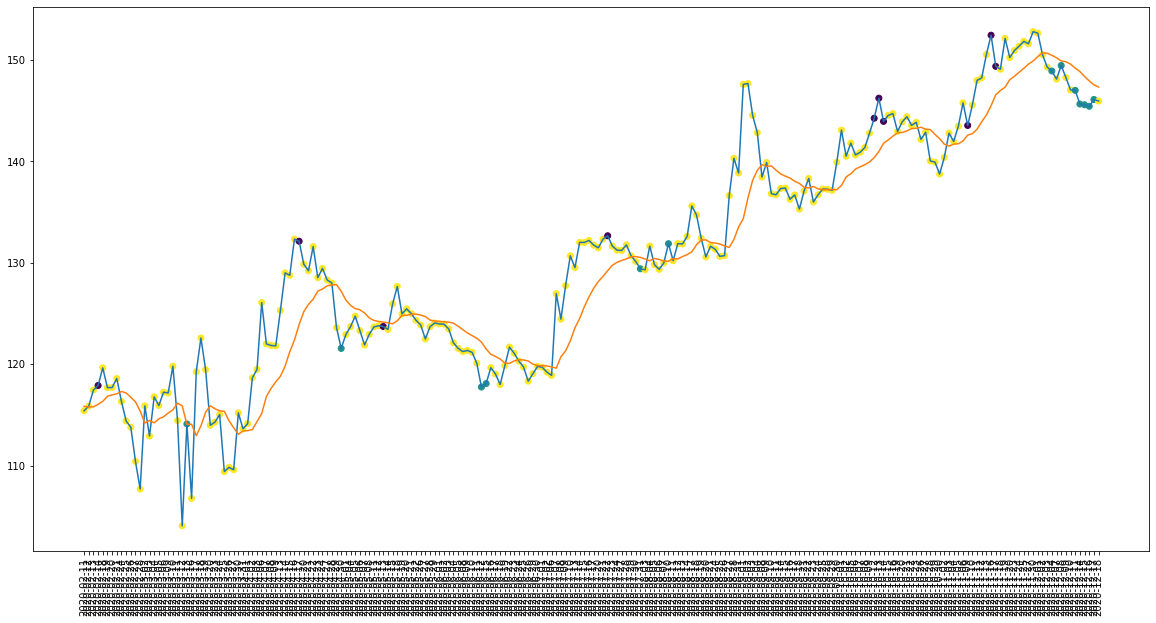

In [149]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

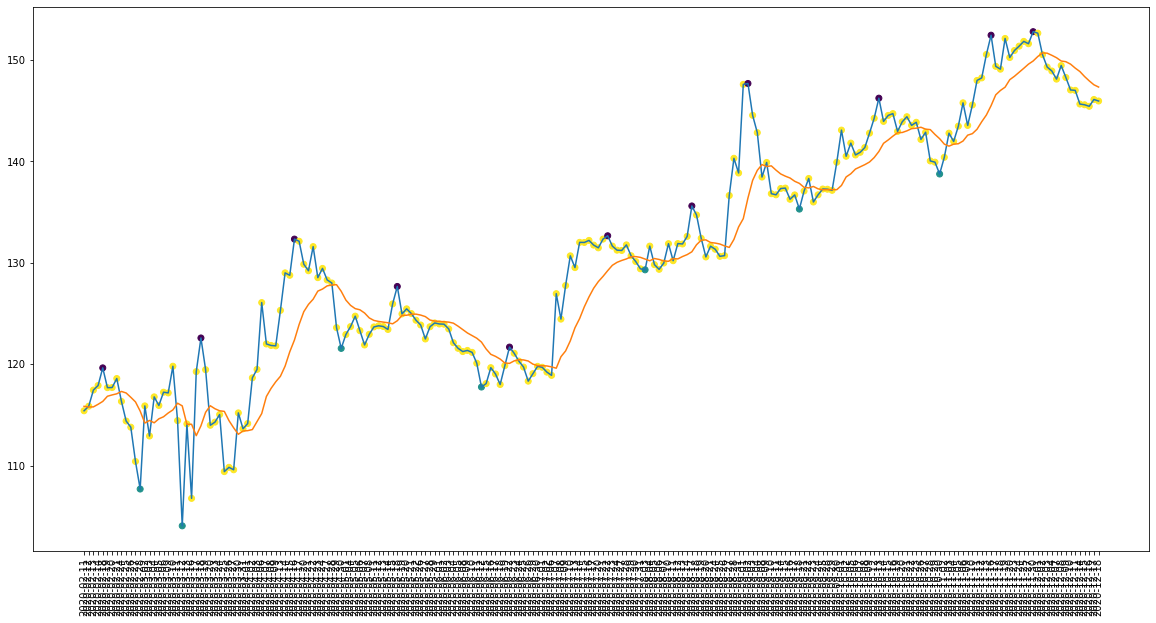

In [150]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [151]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 7
actual predicted holds: 183
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 91.04477611940298%
actual buys: 7
actual sells: 11
actual holds: 201


In [152]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 69.23076923076923%
Percentage sells correct: 60.0%
Percentage holds correct: 86.66666666666667%


In [153]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $114.0999984741211
Shares owned at the moment: 87
Cash capital at the moment: $46.00170811653152


Stop Loss Activated!

Share price: $106.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9308.579563457492


Share price: $121.5500030517578
Shares owned at the moment: 76
Cash capital at the moment: $45.375380886081984


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $8969.007558979036


Share price: $117.73999786376952
Shares owned at the moment: 75
Cash capital at the moment: $114.22384463691924


Price increase from previously bought: 12.362996044081465%
Share price: $132.66000366210938
Shares owned at the moment: 0
Cash capital at the moment: $10036.362993539811


Share price: $129.39999389648438
Shares owned at the moment: 77
Cash capital at the moment: $45.163014802932594


Price increase from previously bought: 11.170330126894502%
Share price: $144.25
Shares owned at the moment:

In [154]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [155]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


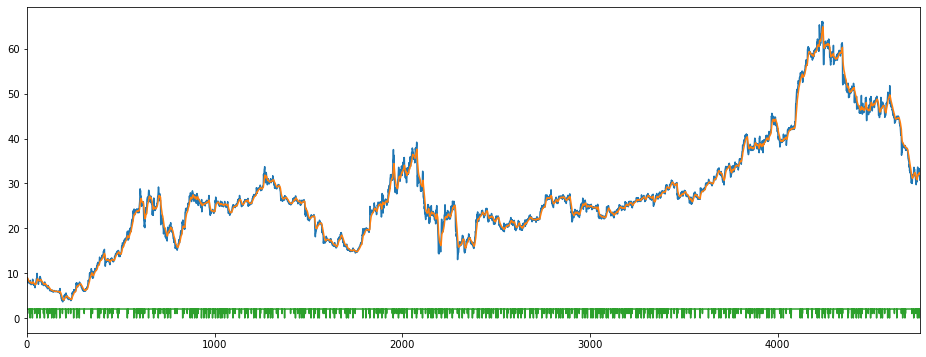

In [156]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [157]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [158]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(4745, 15, 4)

In [159]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [160]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [161]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [225]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [226]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2990 - accuracy: 0.5237 - mse: 0.4416 - weighted_accuracy: 0.2969 - weighted_mse: 0.5297 - val_loss: 0.2993 - val_accuracy: 0.0453 - val_mse: 0.3541 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3541
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2132 - accuracy: 0.3609 - mse: 0.7549 - weighted_accuracy: 0.4270 - weighted_mse: 0.7428 - val_loss: 0.2912 - val_accuracy: 0.0464 - val_mse: 0.3865 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3865
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1909 - accuracy: 0.3135 - mse: 0.9925 - weighted_accuracy: 0.4803 - weighted_mse: 0.9643 - val_loss: 0.2804 - val_accuracy: 0.0464 - val_mse: 0.4284 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4284
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1824 - accuracy: 0.3114 - mse: 1.1366 - weighted_accuracy: 0.5157 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1433 - accuracy: 0.3946 - mse: 1.5342 - weighted_accuracy: 0.6801 - weighted_mse: 1.4566 - val_loss: 0.1872 - val_accuracy: 0.3678 - val_mse: 1.5190 - val_weighted_accuracy: 0.3678 - val_weighted_mse: 1.5190
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1428 - accuracy: 0.4099 - mse: 1.5349 - weighted_accuracy: 0.6911 - weighted_mse: 1.4605 - val_loss: 0.1810 - val_accuracy: 0.4162 - val_mse: 1.5095 - val_weighted_accuracy: 0.4162 - val_weighted_mse: 1.5095
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1406 - accuracy: 0.4197 - mse: 1.5440 - weighted_accuracy: 0.6947 - weighted_mse: 1.4669 - val_loss: 0.1759 - val_accuracy: 0.4636 - val_mse: 1.5643 - val_weighted_accuracy: 0.4636 - val_weighted_mse: 1.5643
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1400 - accuracy: 0.4160 - mse: 1.5656 - weighted_accuracy: 0.6970 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1173 - accuracy: 0.5867 - mse: 1.8470 - weighted_accuracy: 0.8012 - weighted_mse: 1.8330 - val_loss: 0.1765 - val_accuracy: 0.5132 - val_mse: 1.8016 - val_weighted_accuracy: 0.5132 - val_weighted_mse: 1.8016
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1167 - accuracy: 0.5798 - mse: 1.8438 - weighted_accuracy: 0.7969 - weighted_mse: 1.8141 - val_loss: 0.1686 - val_accuracy: 0.5427 - val_mse: 1.8744 - val_weighted_accuracy: 0.5427 - val_weighted_mse: 1.8744
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1161 - accuracy: 0.5814 - mse: 1.8631 - weighted_accuracy: 0.7975 - weighted_mse: 1.8339 - val_loss: 0.1780 - val_accuracy: 0.5026 - val_mse: 1.9079 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 1.9079
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1152 - accuracy: 0.5925 - mse: 1.8873 - weighted_accuracy: 0.7961 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0916 - accuracy: 0.7063 - mse: 2.3030 - weighted_accuracy: 0.8759 - weighted_mse: 2.3388 - val_loss: 0.1649 - val_accuracy: 0.6048 - val_mse: 2.5207 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 2.5207
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0907 - accuracy: 0.7123 - mse: 2.3623 - weighted_accuracy: 0.8691 - weighted_mse: 2.4090 - val_loss: 0.1735 - val_accuracy: 0.6027 - val_mse: 2.4887 - val_weighted_accuracy: 0.6027 - val_weighted_mse: 2.4887
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0902 - accuracy: 0.7131 - mse: 2.3503 - weighted_accuracy: 0.8730 - weighted_mse: 2.3893 - val_loss: 0.1659 - val_accuracy: 0.5996 - val_mse: 2.5635 - val_weighted_accuracy: 0.5996 - val_weighted_mse: 2.5635
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0897 - accuracy: 0.7071 - mse: 2.3985 - weighted_accuracy: 0.8816 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0704 - accuracy: 0.7961 - mse: 3.0923 - weighted_accuracy: 0.9161 - weighted_mse: 3.1608 - val_loss: 0.1658 - val_accuracy: 0.6776 - val_mse: 3.3574 - val_weighted_accuracy: 0.6776 - val_weighted_mse: 3.3574
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0691 - accuracy: 0.7914 - mse: 3.1206 - weighted_accuracy: 0.9144 - weighted_mse: 3.1797 - val_loss: 0.1653 - val_accuracy: 0.6470 - val_mse: 3.2814 - val_weighted_accuracy: 0.6470 - val_weighted_mse: 3.2814
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0680 - accuracy: 0.7966 - mse: 3.2003 - weighted_accuracy: 0.9163 - weighted_mse: 3.2583 - val_loss: 0.1522 - val_accuracy: 0.7102 - val_mse: 3.3553 - val_weighted_accuracy: 0.7102 - val_weighted_mse: 3.3553
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.8253 - mse: 3.2512 - weighted_accuracy: 0.9232 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0544 - accuracy: 0.8538 - mse: 4.2981 - weighted_accuracy: 0.9427 - weighted_mse: 4.2734 - val_loss: 0.1797 - val_accuracy: 0.7007 - val_mse: 4.7892 - val_weighted_accuracy: 0.7007 - val_weighted_mse: 4.7892
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0523 - accuracy: 0.8593 - mse: 4.2896 - weighted_accuracy: 0.9357 - weighted_mse: 4.2438 - val_loss: 0.1552 - val_accuracy: 0.7534 - val_mse: 4.4519 - val_weighted_accuracy: 0.7534 - val_weighted_mse: 4.4519
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 0.8667 - mse: 4.3350 - weighted_accuracy: 0.9474 - weighted_mse: 4.2099 - val_loss: 0.1631 - val_accuracy: 0.7313 - val_mse: 4.5436 - val_weighted_accuracy: 0.7313 - val_weighted_mse: 4.5436
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.8678 - mse: 4.3862 - weighted_accuracy: 0.9478 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.9041 - mse: 5.9636 - weighted_accuracy: 0.9594 - weighted_mse: 5.5543 - val_loss: 0.1733 - val_accuracy: 0.7977 - val_mse: 6.6699 - val_weighted_accuracy: 0.7977 - val_weighted_mse: 6.6699
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0361 - accuracy: 0.9104 - mse: 5.8965 - weighted_accuracy: 0.9671 - weighted_mse: 5.5639 - val_loss: 0.1786 - val_accuracy: 0.7682 - val_mse: 6.4394 - val_weighted_accuracy: 0.7682 - val_weighted_mse: 6.4394
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9057 - mse: 6.0296 - weighted_accuracy: 0.9636 - weighted_mse: 5.6656 - val_loss: 0.1757 - val_accuracy: 0.7808 - val_mse: 6.6418 - val_weighted_accuracy: 0.7808 - val_weighted_mse: 6.6418
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0383 - accuracy: 0.9049 - mse: 6.1979 - weighted_accuracy: 0.9615 - 

In [227]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20559997856616974
Test accuracy: 0.7713382244110107


In [228]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.258894   -1.5408006   1.3686634 ]
 [-1.860298   -2.880016    0.92114466]
 [-0.7485265  -3.477013    0.01748514]
 ...
 [-0.32606968 -4.9711523  -0.6110224 ]
 [-2.3435295  -3.015985    1.1735933 ]
 [ 0.86343    -2.117363   -1.5881907 ]]


Counter({2: 801, 0: 76, 1: 72})

In [229]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [230]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 41
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 36
actual holds but predicted buy: 67
actual holds but predicted sell: 71
actual predicted holds: 724
Percentage buys correct: 6.818181818181818%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 83.9907192575406%
actual buys: 44
actual sells: 43
actual holds: 862


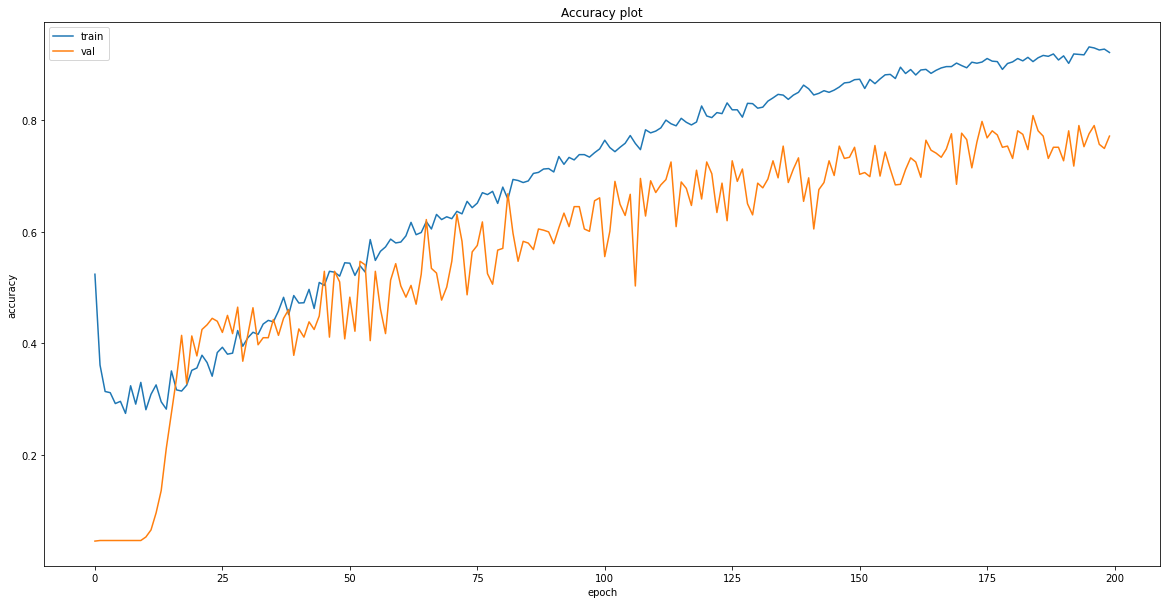

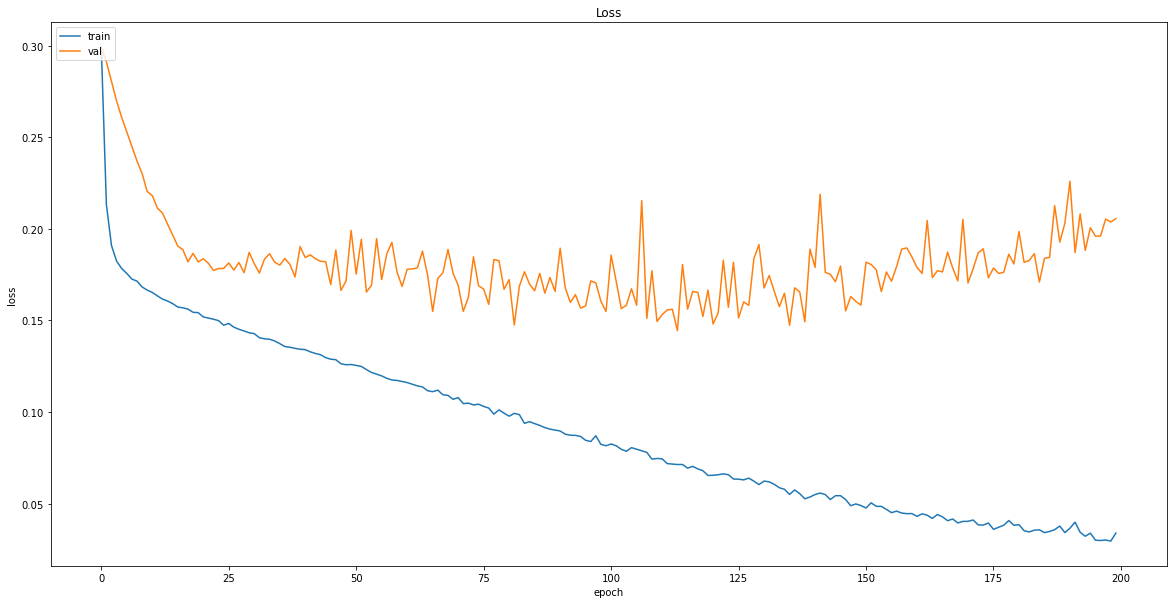

In [231]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [232]:
# Save model
model.save("models/{}".format('fdp_time_series_lstm_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/fdp_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [233]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [234]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [235]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [236]:
model = tf.keras.models.load_model("models/fdp_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2471 - accuracy: 0.7477 - mean_squared_error: 8.2485 - weighted_accuracy: 0.7477 - weighted_mean_squared_error: 8.2485
Test loss: 0.24708545207977295
Test accuracy: 0.747706413269043


In [237]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 0: 17, 1: 24})

In [238]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [239]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [240]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,0,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,0,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


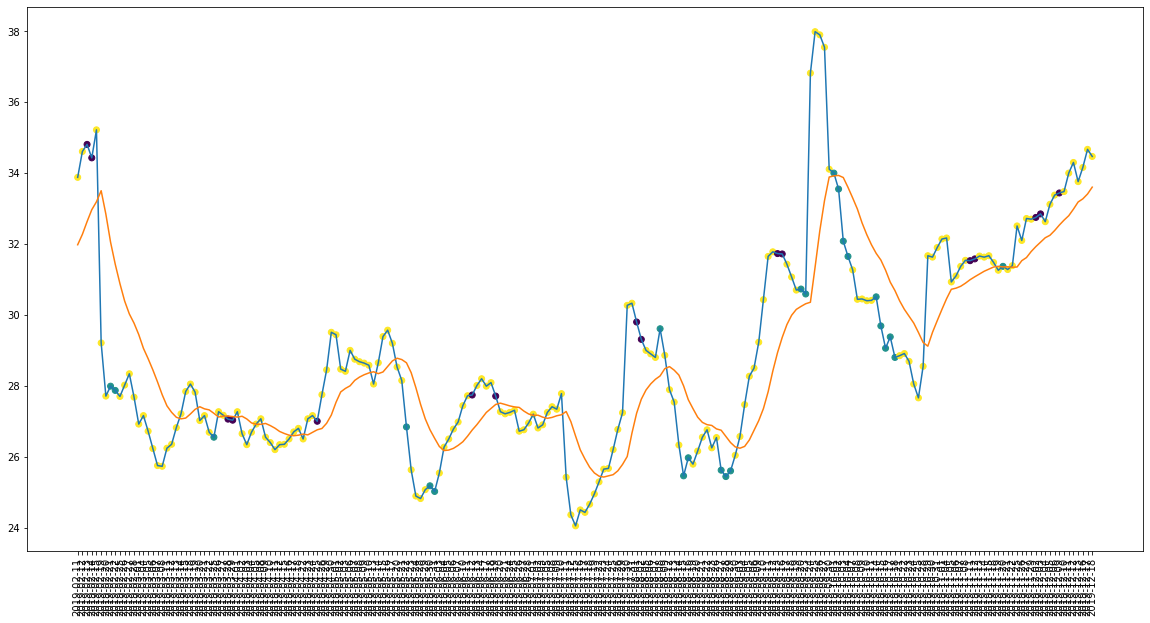

In [241]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

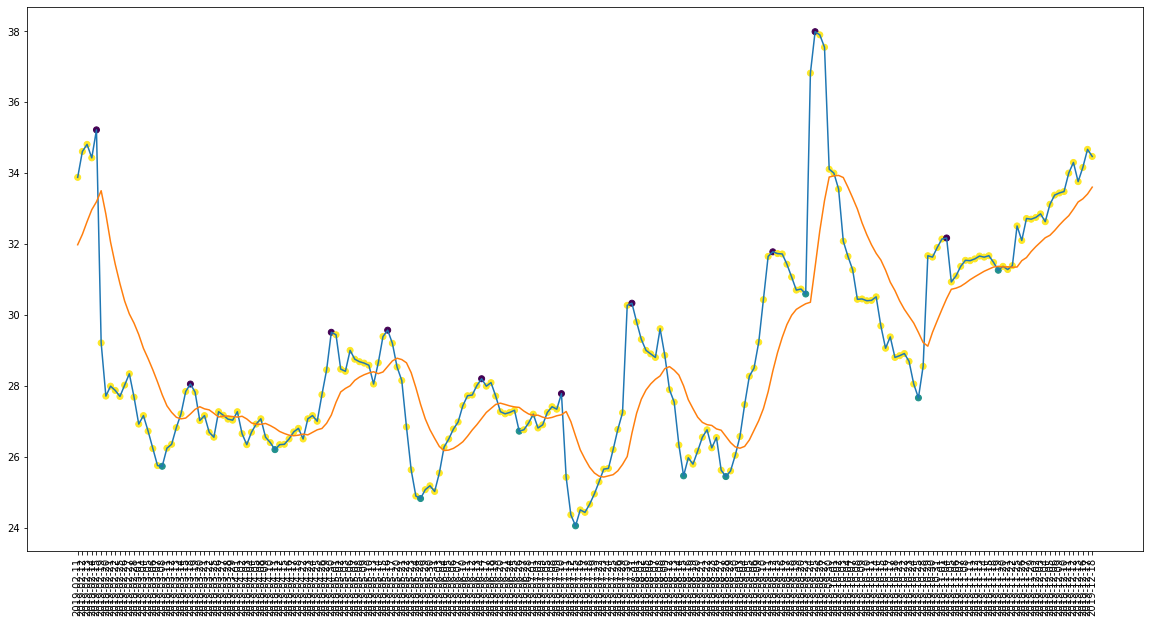

In [242]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [243]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 21
actual holds but predicted sell: 17
actual predicted holds: 160
Percentage buys correct: 30.0%
Percentage sells correct: 0.0%
Percentage holds correct: 80.8080808080808%
actual buys: 10
actual sells: 10
actual holds: 198


In [244]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 58.333333333333336%
Percentage sells correct: 56.25%
Percentage holds correct: 83.61581920903954%


In [245]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.989999771118164
Shares owned at the moment: 356
Cash capital at the moment: $8.157871706009246


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9565.323218791962


Share price: $26.54999923706055
Shares owned at the moment: 359
Cash capital at the moment: $7.662005940435847


Stop Loss Activated!

Share price: $25.6299991607666
Shares owned at the moment: 0
Cash capital at the moment: $9183.528487984178


Share price: $25.18000030517578
Shares owned at the moment: 363
Cash capital at the moment: $18.05244190072699


Price increase from previously bought: 9.864668963035438%
Share price: $27.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10059.980904045102


Share price: $29.61000061035156
Shares owned at the moment: 338
Cash capital at the moment: $24.278202178953507


Stop Loss Activated!

Share price: $27.88999938964844
Shares owned at the moment: 0
Cash capital at the momen

In [246]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [247]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [248]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [249]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [250]:
model = tf.keras.models.load_model("models/fdp_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1854 - accuracy: 0.8219 - mean_squared_error: 7.9282 - weighted_accuracy: 0.8219 - weighted_mean_squared_error: 7.9282
Test loss: 0.1853518784046173
Test accuracy: 0.8219178318977356


In [251]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 12, 2: 192, 1: 15})

In [252]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [253]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [254]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,0,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,0,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


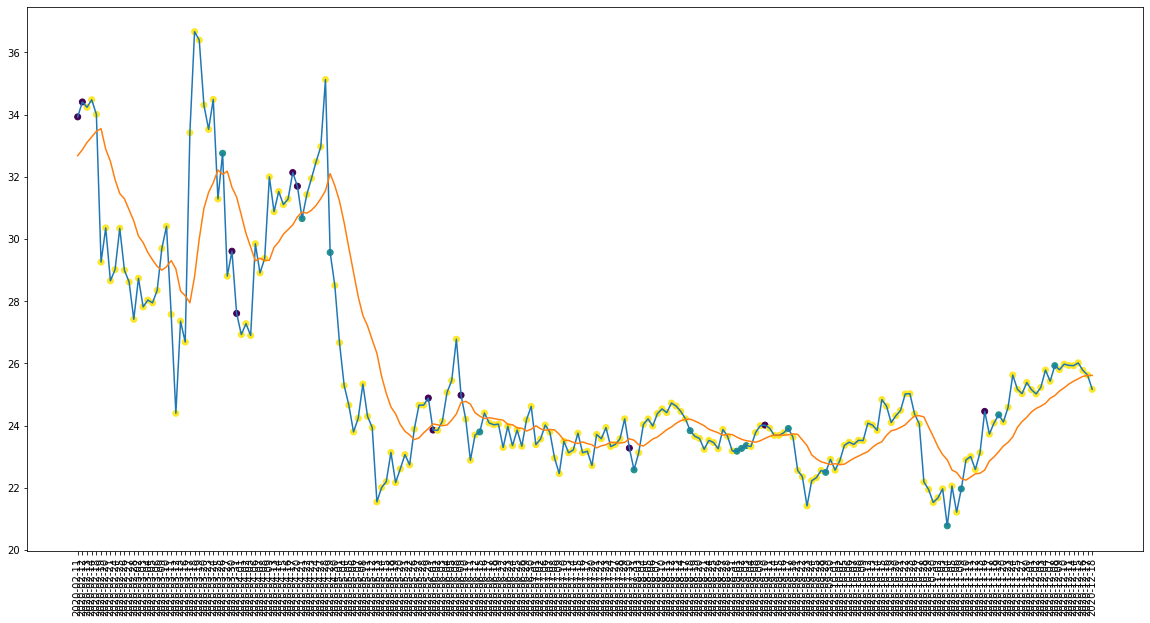

In [255]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

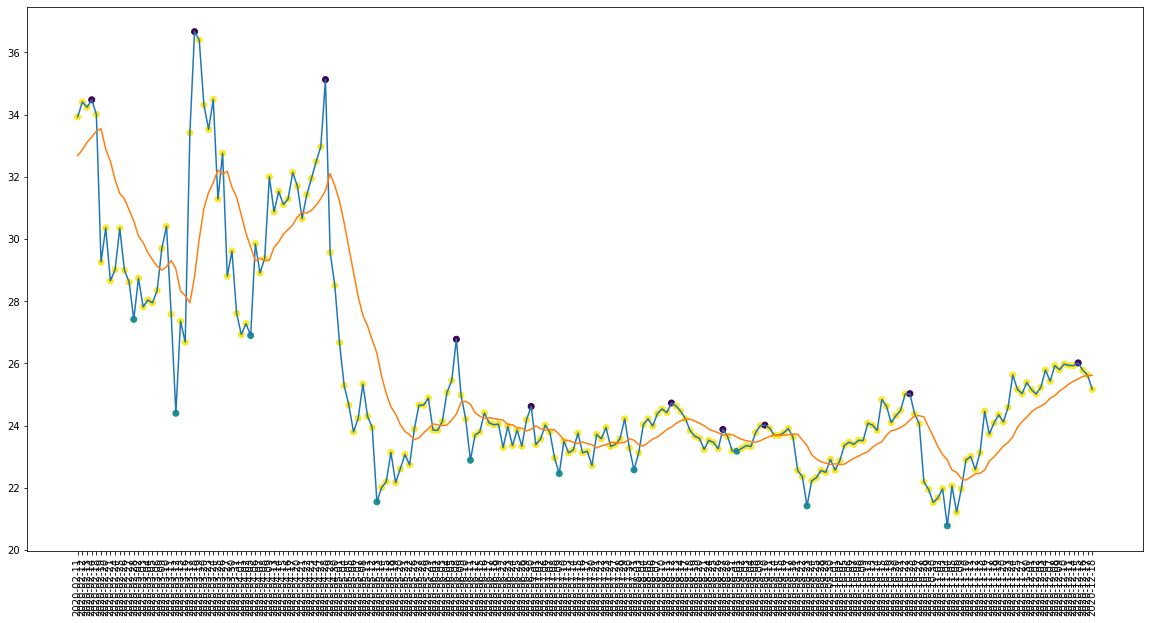

In [256]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [257]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 11
actual predicted holds: 176
Percentage buys correct: 30.0%
Percentage sells correct: 10.0%
Percentage holds correct: 88.44221105527639%
actual buys: 10
actual sells: 10
actual holds: 199


In [258]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 53.333333333333336%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 83.7696335078534%


In [259]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $32.759998321533196
Shares owned at the moment: 304
Cash capital at the moment: $13.573151657106791


Stop Loss Activated!

Share price: $28.809999465942386
Shares owned at the moment: 0
Cash capital at the moment: $8747.727829750065


Share price: $30.65999984741211
Shares owned at the moment: 284
Cash capital at the moment: $16.34241320419642


Stop Loss Activated!

Share price: $29.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $8391.128156772616


Share price: $29.56999969482422
Shares owned at the moment: 282
Cash capital at the moment: $29.456708068850276


Stop Loss Activated!

Share price: $28.51000022888184
Shares owned at the moment: 0
Cash capital at the moment: $8047.167267436031


Share price: $23.79999923706055
Shares owned at the moment: 337
Cash capital at the moment: $4.5108752536789325


Stop Loss Activated!

Share price: $22.959999084472656
Shares owned at the moment: 0
Cash capital at the moment: $7720.752387569429


Share pric

In [260]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
